# Homework 4 - Low Dimensional Embedding
This notebook provides some skeleton code to get you started on the homework. Add in your own code and markdown cells to answer the homework questions. If you want to submit the notebook as a PDF, make sure your code and markdowns are clear and concise to make grading easy for the TAs.
This notebook can be opened in Colab Open In Colab

Before starting, select "Runtime->Factory reset runtime" to start with your directories and environment in the base state.

If you want to save changes to the notebook, select "File->Save a copy in Drive" from the top menu in Colab. This will save the notebook in your Google Drive.





# Clones, imports, and **GPU**

## Use a GPU

You will find this homework much easier if you use a GPU.  Make sure your runtime is set to a GPU.  

In [1]:
# Check if GPU is available and set PyTorch to use the GPU
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: Tesla T4


## Clone GitHub Repository
 Make sure to change directory to `"social_media_analytics"`.

In [2]:
!git clone https://github.com/zlisto/social_media_analytics

import os
os.chdir("social_media_analytics")

Cloning into 'social_media_analytics'...
remote: Enumerating objects: 2652, done.
remote: Counting objects: 100% (2652/2652), done.
remote: Compressing objects: 100% (2244/2244), done.
remote: Total 2652 (delta 426), reused 2628 (delta 403), pack-reused 0
Receiving objects: 100% (2652/2652), 173.92 MiB | 24.16 MiB/s, done.
Resolving deltas: 100% (426/426), done.
Updating files: 100% (1963/1963), done.


## Install UMAP

In [3]:
!pip install umap-learn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.0 MB/s eta 0:00:00


## Import Packages

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import math
import json, re, os
import random

#Instagram analysis
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
from PIL import Image as PILImage
from matplotlib.patches import Ellipse

#Image processing with Resnet
import torch
from torchvision import models, transforms
from sklearn.preprocessing import StandardScaler

#Low dimensional embedding algorithms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

#Clustering algorithms
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#display settings for figures
pd.set_option("display.max_colwidth", None)
plt.rcParams.update({'axes.labelsize': 18,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14})
plt.rcParams['figure.figsize'] = [8, 6]


In [5]:
#Load ResNet
# Load the pretrained ResNet model
resnet = models.resnet50(pretrained=True)
resnet.to(device)
# We're only interested in the embedding, so let's remove the final layer
resnet.fc = torch.nn.Identity()

# Ensure the model is in evaluation mode
resnet.eval()

# Define image transformations for neural network
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 173MB/s]


In [6]:
#Image Processing Functions
# Function to compute embedding vector for all images in file_list
def embed_images(file_list):
    features = []
    for cnt,img_file in enumerate(file_list):
        if cnt % 100 == 0:
            print(f"{cnt}/{len(file_list)} images processed..")
        if img_file.endswith(('png', 'jpg', 'jpeg')):
            img = Image.open(img_file).convert('RGB')
            img_t = transform(img)
            batch_t = torch.unsqueeze(img_t, 0)
            batch_t = batch_t.to(device)
            with torch.no_grad():
                out = resnet(batch_t)
            features.append(out.cpu().flatten().numpy())
    return np.array(features)

# Function to load image from path and downsample it so plots are faster
def loadImage(path, max_size = 100):
    """Resize the image to a maximum dimension of max_size and apply zoom."""
    with PILImage.open(path) as img:
        # Calculate new size, maintaining aspect ratio
        aspect_ratio = img.width / img.height
        if aspect_ratio > 1:  # Width > height
            new_size = (int(max_size * aspect_ratio), max_size)
        else:
            new_size = (max_size, int(max_size / aspect_ratio))
        # Resize image
        img_resized = img.resize(new_size, PILImage.LANCZOS)
        # Convert to array for plt
        img_array = np.array(img_resized)
        # Apply zoom
        return img_array

# Problem 1. Load Image Data (17 points)

Our dataset for this assignment will be images from the Instagram accounts of Cristiano Ronaldo and Lionel Messi, the two greatest football players of this generation.




#### 1. (6 points) Load Messi data

Load the image filenames in the folder `"data/image_compressed_leomessi"` into a list.  Add the list to a dataframe called `df_messi` as a column `image_path`.  Also add a column to the dataframe called `screen_name` that equals `"leomessi"`.    How many image filenames in this dataframe?  Print out your answer.


In [7]:
# Path to your image folder
image_folder = 'data/image_compressed_leomessi'

image_paths = [os.path.join(image_folder, img_file) for img_file in os.listdir(image_folder) if img_file.endswith(('png', 'jpg', 'jpeg'))]

# Function to extract the large number at the beginning of the filename
def extract_number(filepath):
    # Extract the filename from the filepath
    filename = os.path.basename(filepath)
    # Match the pattern: the number at the beginning of the filename before the first underscore
    match = re.search(r'^(\d+)_', filename)
    if match:
        return int(match.group(1))
    return 0  # Return 0 or some default value if no number is found

# Sort the list by the extracted number
image_paths.sort(key=lambda x: extract_number(x))

print(image_folder)
print(f"{len(image_paths)} images")

#dataframe with image info.
df_messi = pd.DataFrame({'image_path':image_paths})

# prompt: add a column to the df_messi called screen_name that equals "leomessi"
df_messi['screen_name'] = 'leomessi'

data/image_compressed_leomessi
500 images


#### 1. (6 points) Load Ronaldo data

Load the image filenames in the folder `"data/image_compressed_cristiano"` into a list.  Add the list to a dataframe called `df_ronaldo` as a column `image_path`. Also add a column to the dataframe called `screen_name` that equals `"cristiano"`.   How many image filenames in this dataframe?  Print out your answer.

In [8]:
# Path to your image folder
image_folder = 'data/image_compressed_cristiano'

image_paths = [os.path.join(image_folder, img_file) for img_file in os.listdir(image_folder) if img_file.endswith(('png', 'jpg', 'jpeg'))]

# Function to extract the large number at the beginning of the filename
def extract_number(filepath):
    # Extract the filename from the filepath
    filename = os.path.basename(filepath)
    # Match the pattern: the number at the beginning of the filename before the first underscore
    match = re.search(r'^(\d+)_', filename)
    if match:
        return int(match.group(1))
    return 0  # Return 0 or some default value if no number is found

# Sort the list by the extracted number
image_paths.sort(key=lambda x: extract_number(x))

print(image_folder)
print(f"{len(image_paths)} images")

#dataframe with image info.
df_ronaldo = pd.DataFrame({'image_path':image_paths})

# prompt: add a column to the df_messi called screen_name that equals "leomessi"
df_ronaldo['screen_name'] = 'cristiano'

data/image_compressed_cristiano
500 images


#### 3. (3 points) Concatenate Dataframes

Concatenate `df_messi` and `df_ronaldo` into one big dataframe along `axis=0` and call it `df`.  The `pd.concat` function may be useful here (ask the AI).  Print out the head of the dataframe.

In [9]:
# prompt: Concatenate df_messi and df_ronaldo into one big dataframe along axis=0 and call it df. The pd.concat function may be useful here. Print out the head of the dataframe.

import pandas as pd
df = pd.concat([df_messi, df_ronaldo], axis=0)
df.head()


,image_path,screen_name
0,data/image_compressed_leomessi/2221199832528747957_427553890_small.jpeg,leomessi
1,data/image_compressed_leomessi/2225132995412106995_427553890_small.jpeg,leomessi
2,data/image_compressed_leomessi/2225132995437288105_427553890_small.jpeg,leomessi
3,data/image_compressed_leomessi/2233064467150170135_427553890_small.jpeg,leomessi
4,data/image_compressed_leomessi/2233064467158730640_427553890_small.jpeg,leomessi


#### 4. (2 points) Histogram of Screen Names

Make a `countplot` of the `screen_name` column in `df`.  Make sure your plot looks nice.

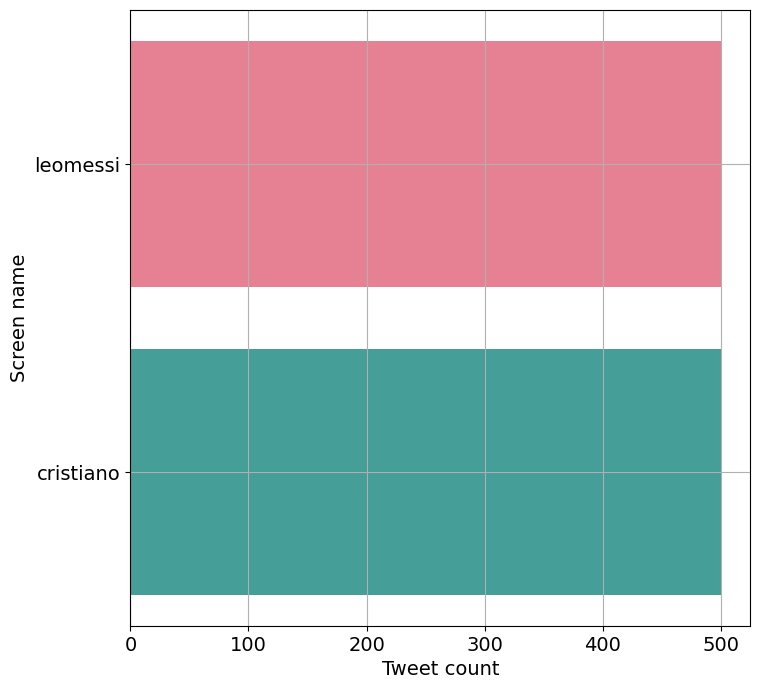

In [10]:
plt.figure(figsize=(8,8))
sns.countplot(data=df, y ='screen_name',
              hue='screen_name',
              palette = "husl")
plt.ylabel("Screen name", fontsize = 14)
plt.xlabel("Tweet count", fontsize = 14)
plt.grid()
plt.show()

# Problem 2.  Image Emeddings (41 points)

Now we will calculate all sorts of embeddings of the images.

#### 1. (14 points) Calculate image embeddings.

Calculate the embedding of all of the images in `df` using the Resnet50 model (you will need to convert the `image_path` column into a list, ask the AI).    Make sure you use the GPU provided in Colab to make things faster.  Also make sure to standardize the embeddings as was done in class. Save the embeddings to an array called `resnet_embedding`.  Print the shape of this embedding array.  





In [12]:
%%time
# Compute embedding using resnet
image_list = df['image_path'].tolist()
resnet_embedding = embed_images(image_list)

# Standardize features
resnet_embedding = StandardScaler().fit_transform(resnet_embedding)
print(f"Shape of resnet embedding matrix is {resnet_embedding.shape}")

0/1000 images processed..
100/1000 images processed..
200/1000 images processed..
300/1000 images processed..
400/1000 images processed..
500/1000 images processed..
600/1000 images processed..
700/1000 images processed..
800/1000 images processed..
900/1000 images processed..
Shape of resnet embedding matrix is (1000, 2048)
CPU times: user 11.3 s, sys: 130 ms, total: 11.4 s
Wall time: 11.6 s


#### 2. (5 points)  PCA Embedding

Compute the two dimensional PCA embedding of `resnet_embedding`.  Save the two PCA components as columns in `df` called `"pca_x"` and `"pca_y"`.

In [13]:
# prompt: Compute the two dimensional PCA embedding of resnet_embedding. Save the two PCA components as columns in df called "pca_x" and "pca_y"

pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(resnet_embedding)
df['pca_x'] = pca_embedding[:, 0]
df['pca_y'] = pca_embedding[:, 1]


#### 4. (5 points) t-SNE Embedding

  Compute the two dimensional t-SNE embedding of `resnet_embedding`.  Save the two t-SNE components as columns in `df` called `"tsne_x"` and `"tsne_y"`.

In [14]:
# prompt: Compute the two dimensional t-SNE embedding of resnet_embedding. Save the two t-SNE components as columns in df called "tsne_x" and "tsne_y"

tsne = TSNE(n_components=2,
            learning_rate='auto',
            init='pca')
tsne_embedding = tsne.fit_transform(resnet_embedding)
df['tsne_x'] = tsne_embedding[:, 0]
df['tsne_y'] = tsne_embedding[:, 1]


#### 5. (5 points) UMAP Embedding

  Compute the two dimensional UMAP embedding of `resnet_embedding`.  Set `n_neighbors=10`, `min_dist=0.1`, and `metric='euclidean`.  Save the two UMAP components as columns in `df` called `"umap_x"` and `"umap_y"`.

In [15]:
# prompt: Compute the two dimensional UMAP embedding of resnet_embedding. Set n_neighbors=10, min_dist=0.1, and metric='euclidean. Save the two UMAP components as columns in df called "umap_x" and "umap_y"

umap = UMAP(n_neighbors=10, min_dist=0.1, metric='euclidean')
umap_embedding = umap.fit_transform(resnet_embedding)
df['umap_x'] = umap_embedding[:, 0]
df['umap_y'] = umap_embedding[:, 1]


#### Advice: Save Dataframe

At this point, we suggest you save `df` to a csv file.  This way you can do the rest of the homework without having to recompute the image embeddings with ResNet50.

In [17]:
# prompt:  save df to a csv file

df.to_csv('processed_data.csv', index=False)


#### 6. (7 points)  Scatter Plot of Embeddings

Make a scatter plot of each embedding (just dots, no images in the plot) and make the `hue` equal to `screen_name`.  Include a title with the embedding name for each plot.    Which embedding do you find most appealing and why?  Print out your answer or write it in a text cell.

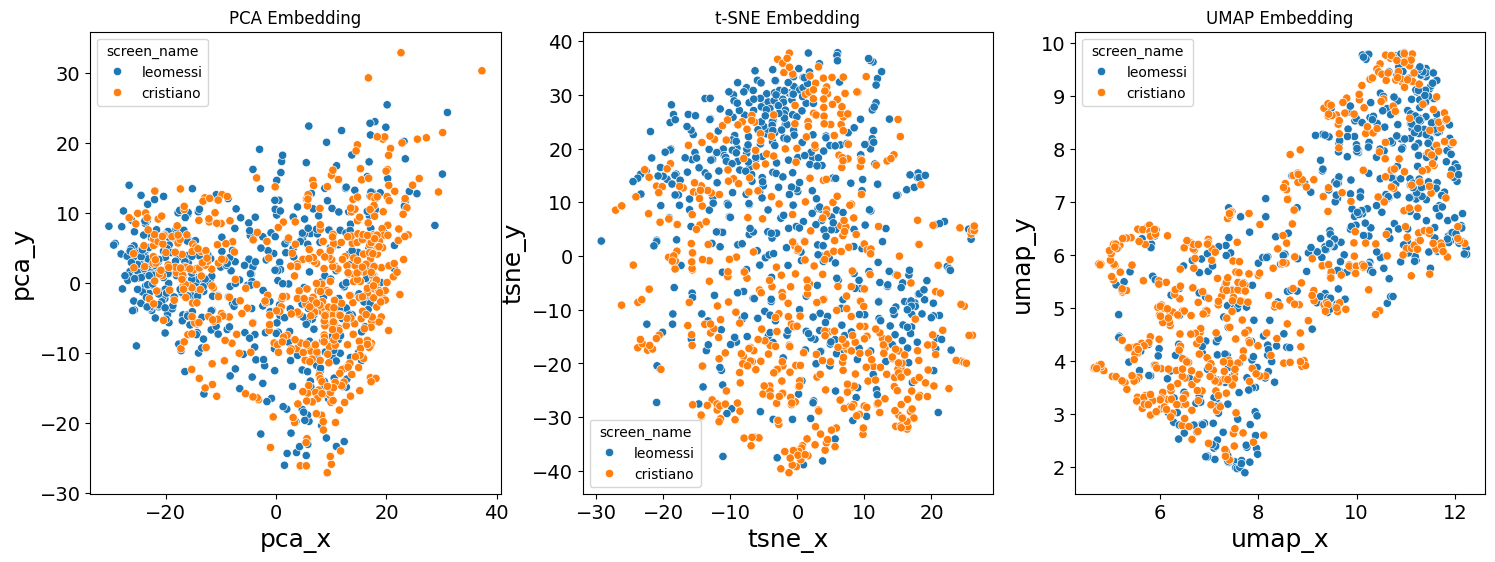

In [18]:
# prompt: Make a scatter plot of each embedding and make the hue equal to screen_name. Include a title with the embedding name for each plot.

import matplotlib.pyplot as plt
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot PCA embedding
sns.scatterplot(ax=axes[0], x="pca_x", y="pca_y", hue="screen_name", data=df)
axes[0].set_title("PCA Embedding")

# Plot t-SNE embedding
sns.scatterplot(ax=axes[1], x="tsne_x", y="tsne_y", hue="screen_name", data=df)
axes[1].set_title("t-SNE Embedding")

# Plot UMAP embedding
sns.scatterplot(ax=axes[2], x="umap_x", y="umap_y", hue="screen_name", data=df)
axes[2].set_title("UMAP Embedding")

# Show the plot
plt.show()


**Which embedding do you like best?**

**Write your answer in this cell**

**UMAP because it has a wider varity and better clusters I think**

#### (5 points) Scatter Plot of UMAP Embeddings with Images

Make a scatterplot of the UMAP embeddings, but this time put a scaled down version of each image at the embedding locations, as was done in class.

In [19]:
#this plots mini versions of the images in a scatter plot (uses a lot of RAM, so be careful)
def plot_image_embedding(df, col_x,col_y,
                         image_zoom = 0.1, #if 900 pics, then try 0.1-0.2
                         max_size = 100):

  x = df[col_x]
  y = df[col_y]
  image_paths = df['image_path']

  fig, ax = plt.subplots(figsize = (10,10))
  ax.scatter(x, y)  # Plotting just for the base scatter plot

  for x0, y0, path in zip(x, y, image_paths):
      img = loadImage(path, max_size)
      ab = AnnotationBbox(OffsetImage(img,
                                      zoom = image_zoom),
                          (x0, y0),
                          frameon=False)
      ax.add_artist(ab)

  return ax

#UMAP is probably the best!

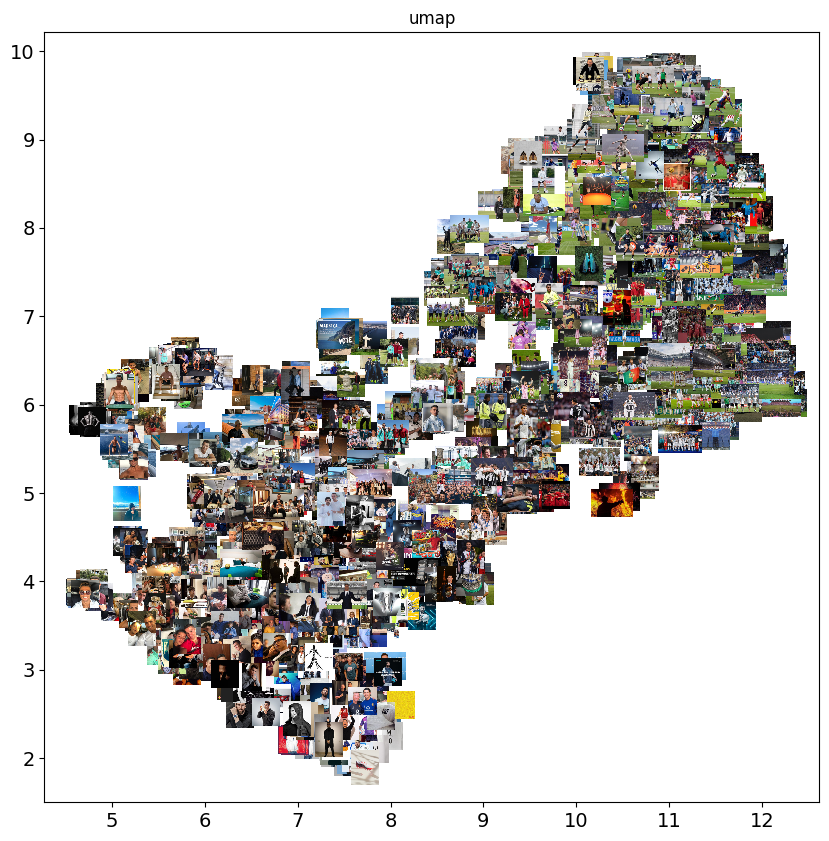

CPU times: user 13.2 s, sys: 206 ms, total: 13.4 s
Wall time: 16.7 s


In [20]:
%%time
embedding_names = ['umap']
image_zoom = 0.2
for embedding_name in embedding_names:
  col_x, col_y = f'{embedding_name}_x', f'{embedding_name}_y'
  ax = plot_image_embedding(df, col_x,col_y, image_zoom)
  ax.set_title(embedding_name)
  plt.show()

# Problem 3:  Clustering Images (42 points)

Now we will analyze the images by clustering their embeddings.

#### 1. (6 points)  2 Clusters

Apply K-means clustering to the UMAP embedding with `k=2` clusters, `n_init='auto'` and `random_state = 0`.  Add these labels to `df` in a column called `kmeans_label_2`.  Make a `countplot` of the `screen_name` distribution for each cluster.  Are the two clusters seperating the two football players Instagram content?

In [23]:
# prompt: Apply K-means clustering to the UMAP embedding with k=2 clusters, n_init='auto' and random_state = 0. Add these labels to df in a column called kmeans_label_2

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, n_init='auto', random_state=0)
df['kmeans_label_2'] = kmeans.fit_predict(df[['umap_x', 'umap_y']])


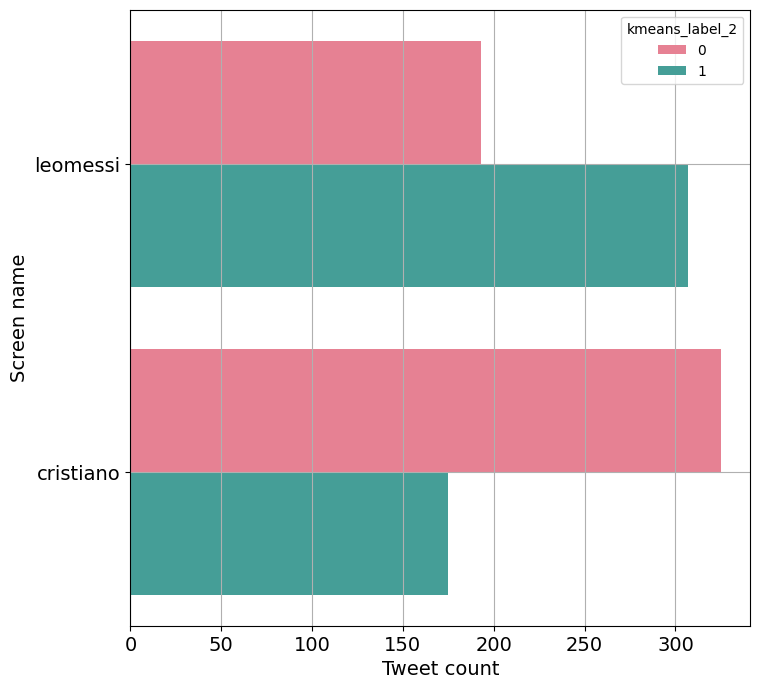

In [24]:
# prompt: Make a countplot of the screen_name distribution for each cluster.

import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
sns.countplot(data=df, y ='screen_name',
              hue='kmeans_label_2',
              palette = "husl")
plt.ylabel("Screen name", fontsize = 14)
plt.xlabel("Tweet count", fontsize = 14)
plt.grid()
plt.show()


#### 2. (10 points) Optimal K-Means Clusters

Calculate the silhouette score of the K-means clusters on the UMAP embedding for `k = 1,2,..., 10`.  Plot the silhouette score vs. `k`.  Which value of `k` has the highest score?  

K = 2, silhouette score = 0.5744112133979797
K = 3, silhouette score = 0.4364429712295532
K = 4, silhouette score = 0.4043672978878021
K = 5, silhouette score = 0.3981063961982727
K = 6, silhouette score = 0.3946947753429413
K = 7, silhouette score = 0.4007306396961212
K = 8, silhouette score = 0.3616540729999542
K = 9, silhouette score = 0.36878344416618347
The silhouette optimal number of clusters (K) is: 2


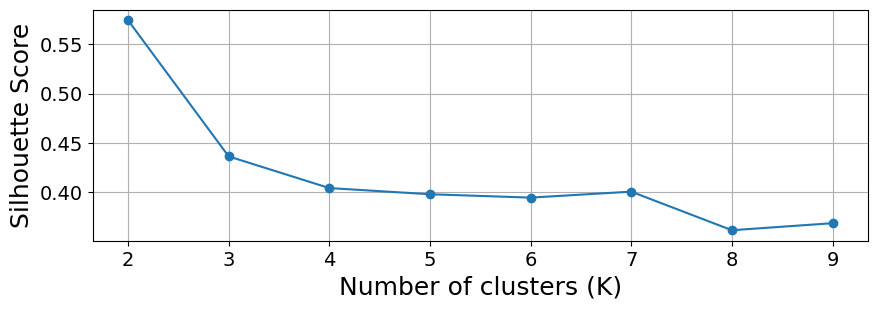

In [25]:
# Choose your embedding to cluster
embedding_name = 'umap'
embedding = df[[f'{embedding_name}_x', f'{embedding_name}_y']].to_numpy()

# Define the range of K values to try
K_range = range(2, 10)  # For example, trying K from 2 to 10

# Prepare a list to store silhouette scores
silhouette_scores = []

# Compute KMeans and silhouette score for each K
for K in K_range:
    kmeans = KMeans(n_clusters=K,
                    random_state=24,
                    n_init='auto')
    kmeans.fit(embedding)
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(embedding, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"K = {K}, silhouette score = {silhouette_avg}")

# Find the optimal K (number of clusters) with the highest silhouette score
optimal_K = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"The silhouette optimal number of clusters (K) is: {optimal_K}")

# Plot silhouette scores over K
plt.figure(figsize=(10, 3))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()

K = 2 has the highest score

#### 4. (6 points) K-means Clusters with a "Good" k

Calculate the K-means clusters of the UMAP embedding using four clusters.  This may not be optimal, but sometimes the silhouette score is not perfect.  Add a column to the dataframe with the tweets called `"kmeans_label"` that contains the K-means cluster labels.  Make a `countplot` of the `screen_name` for each cluster.  

**Optional**: If you want to make it look nicer, use a 2 x 2 subplot for the four count plots.


<ipython-input-32-e13b7539138a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=ax, data=df[df['kmeans_label'] == i], y='screen_name', palette="husl")
<ipython-input-32-e13b7539138a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=ax, data=df[df['kmeans_label'] == i], y='screen_name', palette="husl")
<ipython-input-32-e13b7539138a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=ax, data=df[df['kmeans_label'] == i], y='screen_name', palette="husl")
<ipython-input-32-e13b7539138a>:16: FutureWarning: 

Passing `palette` wi

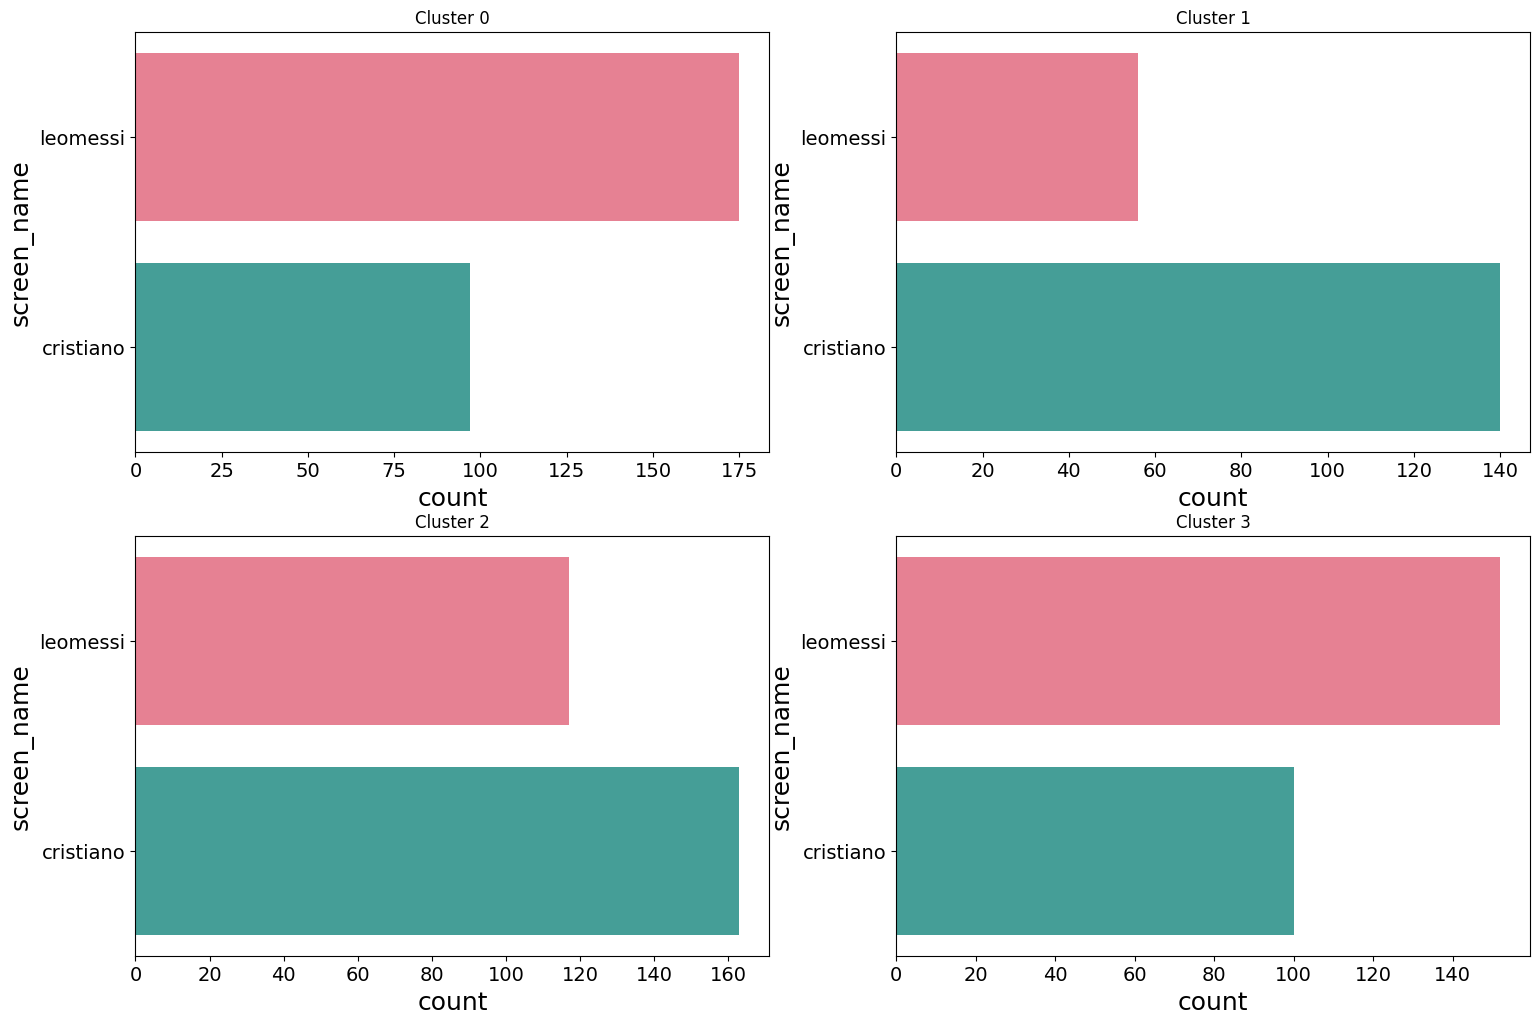

In [32]:
# prompt: Calculate the K-means clusters of the UMAP embedding using four clusters. Add a column to the dataframe with the tweets called "kmeans_label" that contains the K-means cluster labels. Make a countplot of the screen_name for each cluster. Use a 2x2 subplot

import matplotlib.pyplot as plt
# Calculate KMeans clusters with 4 clusters
embedding_name = 'umap'
embedding = df[[f'{embedding_name}_x', f'{embedding_name}_y']].to_numpy()
kmeans = KMeans(n_clusters=4, random_state=24, n_init='auto')
kmeans.fit(embedding)
df['kmeans_label'] = kmeans.labels_

# Create a 2x2 subplot for the four countplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot countplot for each cluster
for i, ax in enumerate(axes.flatten()):
    sns.countplot(ax=ax, data=df[df['kmeans_label'] == i], y='screen_name', palette="husl")
    ax.set_title(f'Cluster {i}')

# Show the plot
plt.show()


#### 6. (6 points) Scatterplot of Clusters

Make two `scatterplot` of the UMAP embeddings.  One has `hue` as the `screen_name` and one has `hue` as `kmeans_label`.  Use the `subplot` function so the plots are side by side.

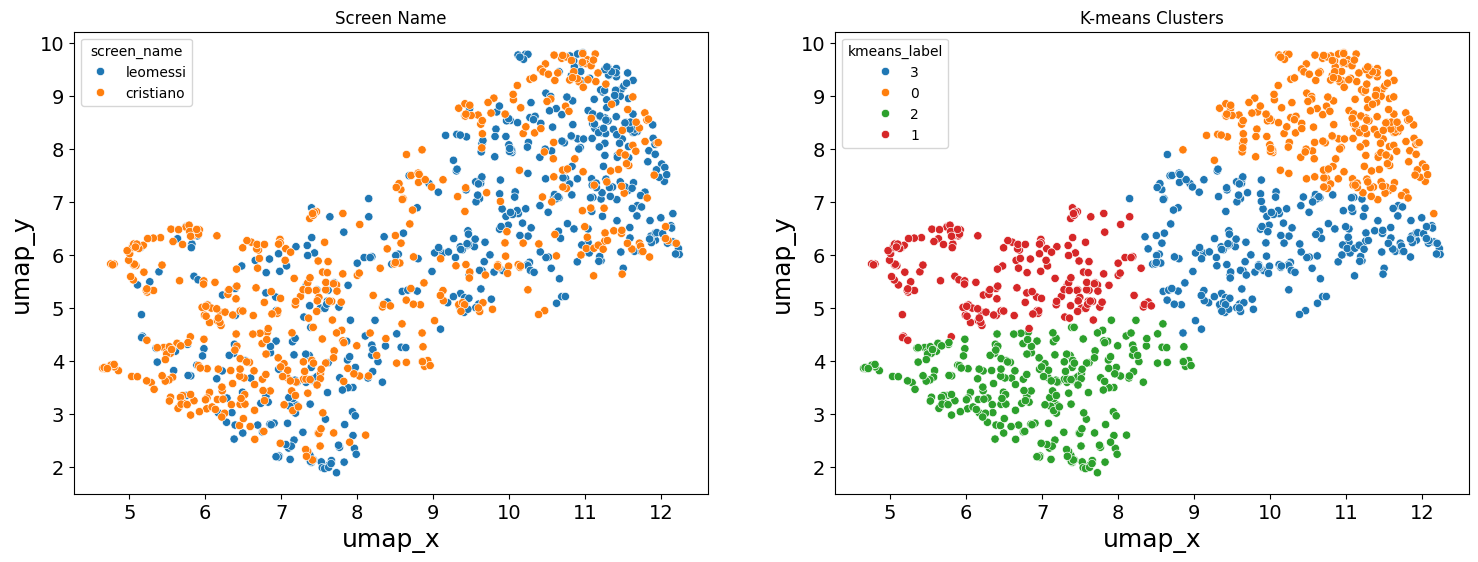

In [27]:
# prompt: Make two scatterplot of the UMAP embeddings. One has hue as the screen_name and one has hue as kmeans_label. Use the subplot function so the plots are side by side.

import matplotlib.pyplot as plt
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot UMAP embedding with hue as screen_name
sns.scatterplot(ax=axes[0], x="umap_x", y="umap_y", hue="screen_name", data=df)
axes[0].set_title("Screen Name")

# Plot UMAP embedding with hue as kmeans_label
sns.scatterplot(ax=axes[1], x="umap_x", y="umap_y", hue="kmeans_label", data=df)
axes[1].set_title("K-means Clusters")

# Show the plot
plt.show()


#### 4. (13 points) Sampling Images in Clusters

Plot 16 samples from each cluster in a 4 x 4 grid, and add the `kmeans_label` to the title for each figure.

**Advice** A `figsize` of `(9,9)` per cluster will look nice.

In [28]:
# prompt: Plot 16 samples from each cluster in a 4 x 4 grid, and add the kmeans_label to the title for each figure. Use figsize of (9,9) per cluster

import matplotlib.pyplot as plt
for label in df['kmeans_label'].unique():
    cluster_data = df[df['kmeans_label'] == label]
    sample_images = cluster_data.sample(16)
    fig, axes = plt.subplots(4, 4, figsize=(9, 9))
    for i, ax in enumerate(axes.flat):
        image_path = sample_images.iloc[i]['image_path']
        img = loadImage(image_path)
        ax.imshow(img)
        ax.axis('off')
    fig.suptitle(f'Cluster {label}')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

#### 5. (1 point) Insights

Based on your analysis of the prevalence of each `screen_name` in each `kmeans_label` cluster, along with your samples of the images in each cluster, provide a summary of what types of images are in the clusters and who posts that type of image more frequently.  

**Optional:** For fun, you can try to infer why each football player posts that type of image.

**Write your answer in this cell**

Cristiano has more posts in cluster 1 and 2 while leomessi has more posts in clusters 3 and 0.

Cluster 0 = running around. kicking the ball. playing soccer. Lots of green grass
Cluster 1 = Social life. Vacations. Hobbies. Hanging out with friends
Cluster 2 = Merch. Shoes. Promotions.
Cluster 3 = Team photos. Group huddles. Lots of blue

Messi seems more serious and posts more serious photos while Cristiano is all about living that fun life and making those sweet deals and fat stacks